In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score

import gc
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from scipy import stats
from keras import optimizers
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
column_defs = pd.read_excel('data\LCDataDictionary.xlsx',index_col='LoanStatNew')
column_defs.columns

Index(['Description'], dtype='object')

In [3]:
def column_info(col_name):
    return column_defs.loc[col_name]['Description']

In [4]:
def na_check(data):
    check = np.round(data.isna().sum().sort_values(ascending=False),2)
    return check

In [5]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
df = pd.read_csv('data/full_clean_pre_z')
df.drop('Unnamed: 0',axis=1,inplace=True)
reduce_mem_usage(df,int_cast=False)

  2%|▏         | 1/50 [00:00<00:09,  5.39it/s]

Memory usage of dataframe is 662.59 MB


100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


Memory usage after optimization is: 374.363 MB
Decreased by 43.5%


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,average_fico,region
0,12000.0,36,10.99,392.799988,B,B2,4,RENT,60000.0,Not Verified,...,0.0,0.0,4.0,100.000000,0.0,7137.0,18100.0,0.0,722.0,South
1,4800.0,36,10.99,157.100006,B,B2,2,MORTGAGE,39600.0,Source Verified,...,0.0,0.0,0.0,100.000000,0.0,4136.0,25700.0,0.0,757.0,South
2,27060.0,36,10.99,885.500000,B,B2,10,OWN,55000.0,Verified,...,0.0,0.0,1.0,100.000000,0.0,70186.0,35700.0,33054.0,732.0,Midwest
3,12000.0,36,7.62,374.000000,A,A3,3,MORTGAGE,96500.0,Not Verified,...,0.0,0.0,3.0,100.000000,0.0,46738.0,14800.0,53404.0,707.0,South
4,14000.0,36,12.85,470.799988,B,B4,4,RENT,88000.0,Not Verified,...,0.0,0.0,0.0,78.599998,1.0,17672.0,3900.0,27340.0,672.0,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,24000.0,60,23.99,690.500000,E,E2,1,RENT,107000.0,Source Verified,...,0.0,1.0,2.0,87.500000,1.0,60812.0,28200.0,64422.0,672.0,West
1736933,10000.0,36,7.99,313.200012,A,A5,10,MORTGAGE,65000.0,Source Verified,...,0.0,0.0,2.0,92.599998,0.0,55863.0,34800.0,70203.0,727.0,Northeast
1736934,10050.0,36,16.99,358.200012,D,D1,8,RENT,37000.0,Not Verified,...,0.0,0.0,5.0,95.199997,0.0,14300.0,9000.0,0.0,707.0,South
1736935,6000.0,36,11.44,197.800003,B,B4,5,RENT,41000.0,Source Verified,...,0.0,0.0,1.0,94.400002,0.0,26201.0,8100.0,34076.0,672.0,Northeast


In [7]:
#list of categorical variables to get ohe
categorical = ['sub_grade',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'region']


cat_drop = ['sub_grade',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'region','loan_status']

In [8]:
cont_columns = df.drop(columns=cat_drop).columns

In [9]:
# removing outliers greater than 4 std deviations to standardize
df_cont_z = df[(np.abs(stats.zscore(df[cont_columns]))<4).all(axis=1)]
z_score_df = df.loc[df_cont_z.index]

In [10]:
onehot = pd.get_dummies(z_score_df[categorical],drop_first=True)

In [11]:
cont = z_score_df.drop(columns=cat_drop)

In [12]:
x= pd.concat([cont,onehot],axis=1)
y= z_score_df['loan_status'].map(lambda x: 1 if x== "Charged Off" else 0)

In [13]:
#splitting our x and y into training and testing samples
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=42)

In [14]:
#importing our priorly smoted x train and y train samples
x_smote = pd.read_csv('data/x_smote_z')
y_smote = pd.read_csv('data/y_smote_z')

In [15]:
# as we dropped columns after testing to our original df need to drop from smote so they aren't included in smote modeling
# at end will need to re run smote 
x_smote.drop(columns=['Unnamed: 0','total_rec_int','total_rec_prncp','total_pymnt',
                 'tot_coll_amt','num_il_tl','delinq_amnt','tax_liens','last_pymnt_amnt'],axis=1,inplace=True)

In [16]:
reduce_mem_usage(x_smote,int_cast=False)

  0%|          | 0/106 [00:00<?, ?it/s]

Memory usage of dataframe is 1314.89 MB


100%|██████████| 106/106 [00:14<00:00,  7.50it/s]


Memory usage after optimization is: 350.430 MB
Decreased by 73.3%


,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,region_Northeast,region_South,region_West
0,7750.000000,36,10.990000,253.800003,3,29000.000000,25.200001,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
1,10000.000000,36,22.910000,386.799988,1,72000.000000,8.200000,1.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,10000.000000,36,12.990000,337.000000,6,40000.000000,22.500000,0.000000,2.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
3,5500.000000,36,16.549999,194.899994,4,54224.000000,20.440001,0.000000,2.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,25000.000000,36,14.520000,861.000000,5,75000.000000,24.980000,0.000000,2.000000,1.000000,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625891,24366.757812,51,17.206345,707.872986,4,117479.695312,21.083889,0.633242,1.100275,0.000000,...,0,0,0,0,0,0,0,0,1,0
1625892,19482.703125,50,15.419235,542.377869,5,51204.097656,22.845705,0.000000,0.602049,0.602049,...,0,0,0,0,0,0,0,0,0,0
1625893,13179.145508,36,14.562667,461.734833,6,55000.000000,18.415403,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1625894,17840.857422,45,21.473141,597.083801,8,54589.417969,23.626722,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [17]:
y_smote.drop('Unnamed: 0',axis=1,inplace=True)
reduce_mem_usage(y_smote,int_cast=False)

100%|██████████| 1/1 [00:00<00:00, 142.86it/s]

Memory usage of dataframe is 12.40 MB
Memory usage after optimization is: 1.551 MB
Decreased by 87.5%


,loan_status
0,0
1,1
2,0
3,1
4,1
...,...
1625891,1
1625892,1
1625893,1
1625894,1


In [18]:
scaler = MinMaxScaler()

In [19]:
#scaling our smote training samples
x_smote_cont =  pd.DataFrame(scaler.fit_transform(x_smote[cont_columns]),columns=cont_columns)
x_smote_scaled = pd.concat([x_smote_cont,x_smote[onehot.columns]],axis=1)

#scaling for our x test sample
x_test= x_test.reset_index().drop('index',axis=1)
x_test_cont_scaled = pd.DataFrame(scaler.transform(x_test[cont_columns]),columns=cont_columns)
x_test_scaled = pd.concat([x_test_cont_scaled,x_test[onehot.columns]],axis=1)

In [20]:
#further splitting our training into validation sets we will use in crossvalidation
x_train_final, x_val, y_train_final, y_val = train_test_split(x_smote_scaled, y_smote, test_size=.3,random_state=42)

In [21]:
x_train = x_train.reset_index().drop('index',axis=1)
x_cont =  pd.DataFrame(scaler.fit_transform(x_train[cont_columns]),columns=cont_columns)
x_train_scaled = pd.concat([x_cont,x_train[onehot.columns]],axis=1)

In [22]:
y_train = y_train.reset_index().drop('index',axis=1)

In [23]:
## Relevant feature groups
#for testing unsmoted without recoveries
og_no =['loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
 'revol_bal','average_fico','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mort_acc','mths_since_recent_bc','mths_since_recent_inq',
 'num_accts_ever_120_pd','num_bc_sats','num_bc_tl','num_op_rev_tl','num_tl_90g_dpd_24m',
'num_tl_op_past_12m','pct_tl_nvr_dlq','pub_rec_bankruptcies','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G','home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation',
'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_other','purpose_renewable_energy',
'purpose_small_business','purpose_vacation','purpose_wedding','application_type_Joint App', 'region_South','region_West']

#for testing unsmoted with recoveries
og_yes = ['recoveries',
'loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs',
 'revol_bal','average_fico','total_acc','total_rec_late_fee','tot_cur_bal','bc_util',
 'mort_acc','mths_since_recent_bc','mths_since_recent_inq',
'num_bc_sats','num_bc_tl','num_op_rev_tl','num_tl_90g_dpd_24m',
'num_tl_op_past_12m','pct_tl_nvr_dlq','pub_rec_bankruptcies','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G','home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation',
'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_other',
'purpose_vacation','purpose_wedding','application_type_Joint App', 'region_South','region_West']

#for testing smoted samples with recoveries
recover = ['recoveries',
'loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
'pub_rec', 'revol_bal','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mths_since_recent_bc', 'num_accts_ever_120_pd',
 'num_bc_sats', 'num_bc_tl',
 'num_op_rev_tl', 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
 'total_bal_ex_mort', 'total_bc_limit',
 'total_il_high_credit_limit','average_fico',
 'sub_grade_A2',
 'sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
 'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2',
 'sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1'
,'sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4',
 'sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5',
 'home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified',
 'purpose_credit_card','purpose_debt_consolidation','purpose_home_improvement','purpose_house','purpose_major_purchase',
'purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation', 'purpose_wedding','purpose_medical',
'purpose_moving',
'application_type_Joint App',
 'region_South','region_West','region_Northeast']

no_recover = ['loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
'pub_rec', 'revol_bal','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mths_since_recent_bc', 'num_accts_ever_120_pd',
 'num_bc_sats', 'num_bc_tl',
 'num_op_rev_tl', 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
 'total_bal_ex_mort', 'total_bc_limit',
 'total_il_high_credit_limit','average_fico',
 'sub_grade_A2',
 'sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
 'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2',
 'sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1'
,'sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4',
 'sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5',
 'home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified',
 'purpose_credit_card','purpose_debt_consolidation','purpose_home_improvement','purpose_house','purpose_major_purchase',
'purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation', 'purpose_wedding','purpose_medical',
'purpose_moving',
'application_type_Joint App',
 'region_South','region_West','region_Northeast']

In [24]:
n_feats = x_smote_scaled[no_recover].shape[1]
n_feats

83

In [25]:
grade_columns = ['grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G']

all_grades = ['grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G','sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']

In [195]:
def visualize_training_results_accur(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [197]:
def visualize_training_results_acc(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [27]:
def test_class_report(saved_model_name,x_test,y_test,x_train,y_train):
    model = load_model(saved_model_name)
    train = model.evaluate(x_train,y_train)
    print(f'Training Loss: {train[0]:.3} \nTraining Accuracy: {train[1]:.3}')
    print('----------')
    test = model.evaluate(x_test,y_test)
    print(f'Test Loss: {test[0]:.3} \nTest Accuracy: {test[1]:.3}')
    preds = model.predict_classes(x_test)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    

## Baseline ANN

In [28]:
y_train_final = y_train_final.loan_status

In [29]:
y_train_final.shape

(1138127,)

In [390]:
#creating a function to run multiple layer tests
def evaluate_model(n_layers, trainX, trainy, testX, testy,xval,yval,feature):
# configure the model based on the data
    n_input, n_classes = trainX[feature].shape[1], 1
    # define model
    model = models.Sequential()
    model.add(layers.Dense(50, input_dim=n_input, activation='tanh'))
    for _ in range(1, n_layers):
        model.add(layers.Dense(25, activation='tanh'))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train set
    early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    history = model.fit(trainX[feature], trainy, epochs=150,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval[feature],yval))
    # evaluate model on test set
    saved= load_model('best_model.h5')
    _, test_acc = saved.evaluate(testX[feature], testy, verbose=1)
    return history, test_acc

In [33]:
x_train_final[no_recover].shape[1]

83

In [58]:
#base with tanh activation
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(150,activation='tanh',input_shape=(83,)))
baseline_model.add(layers.Dense(75,activation='tanh'))
baseline_model.add(layers.Dense(40,activation='tanh'))
baseline_model.add(layers.Dense(20,activation='tanh'))
baseline_model.add(layers.Dense(10,activation='tanh'))
baseline_model.add(layers.Dense(1,activation='sigmoid'))

baseline_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=25), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [59]:
base_result = baseline_model.fit(x_train_final[no_recover],y_train_final,
                               epochs=150,batch_size=200,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/150
5691/5691 [==============================] - 10s 2ms/step - loss: 0.3158 - acc: 0.8597 - val_loss: 0.3000 - val_acc: 0.8675
Epoch 2/150
5691/5691 [==============================] - 10s 2ms/step - loss: 0.2940 - acc: 0.8714 - val_loss: 0.2864 - val_acc: 0.8761
Epoch 3/150
5691/5691 [==============================] - 10s 2ms/step - loss: 0.2878 - acc: 0.8750 - val_loss: 0.2824 - val_acc: 0.8783
Epoch 4/150
5691/5691 [==============================] - 10s 2ms/step - loss: 0.2851 - acc: 0.8766 - val_loss: 0.2821 - val_acc: 0.8779
Epoch 5/150
5691/5691 [==============================] - 9s 2ms/step - loss: 0.2834 - acc: 0.8773 - val_loss: 0.2815 - val_acc: 0.8778
Epoch 6/150
5691/5691 [==============================] - 9s 2ms/step - loss: 0.2825 - acc: 0.8777 - val_loss: 0.2833 - val_acc: 0.8777
Epoch 7/150
5691/5691 [==============================] - 9s 2ms/step - loss: 0.2814 - acc: 0.8784 - val_loss: 0.2820 - val_acc: 0.8773
Epoch 8/150
5691/5691 [============================

In [60]:
base_save = load_model('best_model.h5')

In [61]:
test_class_report('best_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 20s 566us/step - loss: 0.2687 - acc: 0.8851
Training Loss: 0.269 
Training Accuracy: 0.885
----------
13643/13643 [==============================] - 16s 1ms/step - loss: 0.4201 - acc: 0.8242
Test Loss: 0.42 
Test Accuracy: 0.824
[[346806   9740]
 [ 66992  13025]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    356546
           1       0.57      0.16      0.25     80017

    accuracy                           0.82    436563
   macro avg       0.71      0.57      0.58    436563
weighted avg       0.79      0.82      0.78    436563



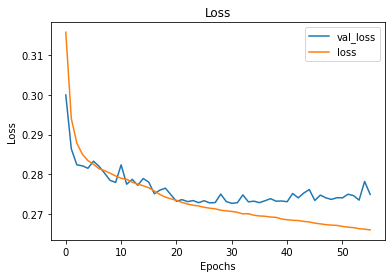

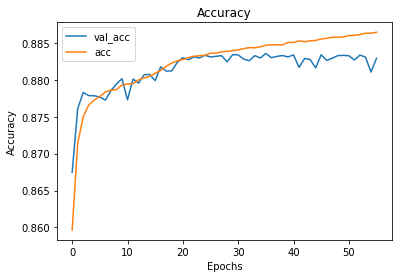

In [63]:
visualize_training_results(base_result)

Our baseline has an accuracy of .82 but our recall score at .17 for our target class can use improvement

In [65]:
baseline_model2 = models.Sequential()
baseline_model2.add(layers.Dense(150,activation='relu',input_shape=(83,)))
baseline_model2.add(layers.Dense(75,activation='relu'))
baseline_model2.add(layers.Dense(40,activation='relu'))
baseline_model2.add(layers.Dense(20,activation='relu'))
baseline_model2.add(layers.Dense(10,activation='relu'))
baseline_model2.add(layers.Dense(1,activation='sigmoid'))

baseline_model2.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=25), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [66]:
base_result2 = baseline_model2.fit(x_train_final[no_recover],y_train_final,
                               epochs=150,batch_size=200,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/150
5691/5691 [==============================] - 9s 2ms/step - loss: 0.3080 - acc: 0.8629 - val_loss: 0.2915 - val_acc: 0.8738
Epoch 2/150
5691/5691 [==============================] - 9s 1ms/step - loss: 0.2881 - acc: 0.8752 - val_loss: 0.2830 - val_acc: 0.8777
Epoch 3/150
5691/5691 [==============================] - 8s 1ms/step - loss: 0.2840 - acc: 0.8773 - val_loss: 0.2843 - val_acc: 0.8766
Epoch 4/150
5691/5691 [==============================] - 9s 2ms/step - loss: 0.2809 - acc: 0.8789 - val_loss: 0.2788 - val_acc: 0.8804
Epoch 5/150
5691/5691 [==============================] - 8s 1ms/step - loss: 0.2782 - acc: 0.8802 - val_loss: 0.2770 - val_acc: 0.8810
Epoch 6/150
5691/5691 [==============================] - 9s 2ms/step - loss: 0.2763 - acc: 0.8812 - val_loss: 0.2744 - val_acc: 0.8824
Epoch 7/150
5691/5691 [==============================] - 9s 2ms/step - loss: 0.2750 - acc: 0.8818 - val_loss: 0.2766 - val_acc: 0.8811
Epoch 8/150
5691/5691 [==============================] 

In [67]:
base_save2 = load_model('best_model.h5')
test_class_report('best_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 18s 515us/step - loss: 0.2630 - acc: 0.8881
Training Loss: 0.263 
Training Accuracy: 0.888
----------
13643/13643 [==============================] - 12s 847us/step - loss: 0.4201 - acc: 0.8237
Test Loss: 0.42 
Test Accuracy: 0.824
[[346622   9924]
 [ 67041  12976]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    356546
           1       0.57      0.16      0.25     80017

    accuracy                           0.82    436563
   macro avg       0.70      0.57      0.58    436563
weighted avg       0.79      0.82      0.78    436563



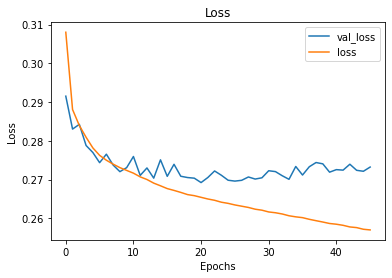

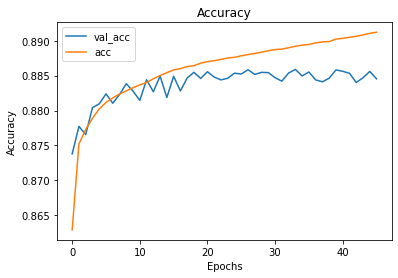

In [68]:
visualize_training_results(base_result2)

In [69]:

# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_layers, trainX, trainy, testX, testy,xval,yval,feature):
# configure the model based on the data
    n_input, n_classes = trainX[feature].shape[1], 1
    # define model
    nodes=500
    model = models.Sequential()
    model.add(layers.Dense(nodes, input_dim=n_input, activation='tanh'))
    for x in range(1, n_layers):
        nodes = nodes/2
        model.add(layers.Dense(nodes, activation='tanh'))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model on train set
    early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    history = model.fit(trainX[feature], trainy, epochs=250,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval[feature],yval))
    # evaluate model on test set
    saved= load_model('best_model.h5')
    _, test_acc = saved.evaluate(testX[feature], testy, verbose=1)
    return history, test_acc

## Tuning Layers

Epoch 1/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.3100 - accuracy: 0.8623 - val_loss: 0.2906 - val_accuracy: 0.8735
Epoch 2/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2909 - accuracy: 0.8735 - val_loss: 0.2873 - val_accuracy: 0.8755
Epoch 3/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2878 - accuracy: 0.8749 - val_loss: 0.2839 - val_accuracy: 0.8772
Epoch 4/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2855 - accuracy: 0.8763 - val_loss: 0.2823 - val_accuracy: 0.8780
Epoch 5/250
4446/4446 [==============================] - 14s 3ms/step - loss: 0.2840 - accuracy: 0.8769 - val_loss: 0.2824 - val_accuracy: 0.8781
Epoch 6/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2830 - accuracy: 0.8773 - val_loss: 0.2813 - val_accuracy: 0.8784
Epoch 7/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2821 - accuracy: 0.8779 - val_loss: 0.2823 -

4446/4446 [==============================] - 16s 4ms/step - loss: 0.2788 - accuracy: 0.8798 - val_loss: 0.2783 - val_accuracy: 0.8805
Epoch 18/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2783 - accuracy: 0.8799 - val_loss: 0.2777 - val_accuracy: 0.8808
Epoch 19/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2777 - accuracy: 0.8804 - val_loss: 0.2778 - val_accuracy: 0.8805
Epoch 20/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2768 - accuracy: 0.8810 - val_loss: 0.2761 - val_accuracy: 0.8816
Epoch 21/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2762 - accuracy: 0.8813 - val_loss: 0.2759 - val_accuracy: 0.8819
Epoch 22/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2757 - accuracy: 0.8816 - val_loss: 0.2753 - val_accuracy: 0.8822
Epoch 23/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2758 - accuracy: 0.8818 - val_loss: 0.2753 - val_a

4446/4446 [==============================] - 15s 3ms/step - loss: 0.2781 - accuracy: 0.8799 - val_loss: 0.2788 - val_accuracy: 0.8797
Epoch 17/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2770 - accuracy: 0.8809 - val_loss: 0.2764 - val_accuracy: 0.8811
Epoch 18/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2764 - accuracy: 0.8811 - val_loss: 0.2769 - val_accuracy: 0.8811
Epoch 19/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2761 - accuracy: 0.8813 - val_loss: 0.2760 - val_accuracy: 0.8812
Epoch 20/250
4446/4446 [==============================] - 16s 3ms/step - loss: 0.2757 - accuracy: 0.8815 - val_loss: 0.2757 - val_accuracy: 0.8816
Epoch 21/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2756 - accuracy: 0.8816 - val_loss: 0.2753 - val_accuracy: 0.8825
Epoch 22/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2755 - accuracy: 0.8818 - val_loss: 0.2749 - val_a

4446/4446 [==============================] - 16s 4ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 7/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 8/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 9/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 10/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 11/250
13643/13643 [==============================] - 11s 827us/step - loss: 0.6933 - accuracy: 0.8167
layers=15: 0.817


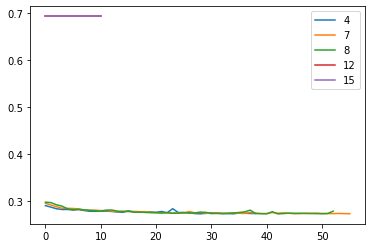

In [70]:
# evaluate model and plot learning curve of model with given number of layers
num_layers = [4,7,8,12,15]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, x_train_final,y_train_final, x_test_scaled, y_test,x_val,y_val,no_recover)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['val_loss'], label=(str(n_layers)))
plt.legend()
plt.show()

Epoch 1/250
4446/4446 [==============================] - 17s 4ms/step - loss: 0.3121 - accuracy: 0.8618 - val_loss: 0.2976 - val_accuracy: 0.8681
Epoch 2/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2952 - accuracy: 0.8707 - val_loss: 0.2895 - val_accuracy: 0.8738
Epoch 3/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2896 - accuracy: 0.8743 - val_loss: 0.2894 - val_accuracy: 0.8746
Epoch 4/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2868 - accuracy: 0.8757 - val_loss: 0.2843 - val_accuracy: 0.8761
Epoch 5/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2857 - accuracy: 0.8762 - val_loss: 0.2855 - val_accuracy: 0.8760
Epoch 6/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2845 - accuracy: 0.8767 - val_loss: 0.2845 - val_accuracy: 0.8758
Epoch 7/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2836 - accuracy: 0.8771 - val_loss: 0.2817 -

4446/4446 [==============================] - 16s 4ms/step - loss: 0.2815 - accuracy: 0.8780 - val_loss: 0.2794 - val_accuracy: 0.8794
Epoch 11/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2808 - accuracy: 0.8787 - val_loss: 0.2794 - val_accuracy: 0.8796
Epoch 12/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2802 - accuracy: 0.8789 - val_loss: 0.2786 - val_accuracy: 0.8799
Epoch 13/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2798 - accuracy: 0.8791 - val_loss: 0.2786 - val_accuracy: 0.8797
Epoch 14/250
4446/4446 [==============================] - 17s 4ms/step - loss: 0.2790 - accuracy: 0.8797 - val_loss: 0.2826 - val_accuracy: 0.8771
Epoch 15/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2781 - accuracy: 0.8802 - val_loss: 0.2766 - val_accuracy: 0.8815
Epoch 16/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2773 - accuracy: 0.8808 - val_loss: 0.2754 - val_a

4446/4446 [==============================] - 15s 3ms/step - loss: 0.2797 - accuracy: 0.8793 - val_loss: 0.2783 - val_accuracy: 0.8801
Epoch 16/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2793 - accuracy: 0.8793 - val_loss: 0.2781 - val_accuracy: 0.8801
Epoch 17/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2782 - accuracy: 0.8801 - val_loss: 0.2776 - val_accuracy: 0.8807
Epoch 18/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2770 - accuracy: 0.8808 - val_loss: 0.2767 - val_accuracy: 0.8816
Epoch 19/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2769 - accuracy: 0.8809 - val_loss: 0.2760 - val_accuracy: 0.8820
Epoch 20/250
4446/4446 [==============================] - 16s 4ms/step - loss: 0.2762 - accuracy: 0.8815 - val_loss: 0.2750 - val_accuracy: 0.8821
Epoch 21/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.2760 - accuracy: 0.8814 - val_loss: 0.2781 - val_a

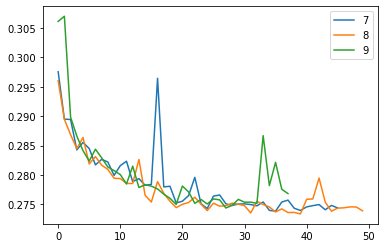

In [71]:
# evaluate model and plot learning curve of model with given number of layers
num_layers = [7,8,9]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, x_train_final,y_train_final, x_test_scaled, y_test,x_val,y_val,no_recover)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['val_loss'], label=(str(n_layers)))
plt.legend()
plt.show()

Above we tested for varying layers to see which was able to achieve the lowest loss in the validation data of which 8 appeared to perform the best

In [393]:
base3 = models.Sequential()
base3.add(layers.Dense(300, input_dim=83, activation='tanh'))
base3.add(layers.Dense(250, activation='tanh'))
base3.add(layers.Dense(125, activation='tanh'))
base3.add(layers.Dense(62, activation='tanh'))
base3.add(layers.Dense(31, activation='tanh'))
base3.add(layers.Dense(15, activation='tanh'))
base3.add(layers.Dense(7, activation='tanh'))
base3.add(layers.Dense(3, activation='tanh'))
base3.add(layers.Dense(1, activation='sigmoid'))


# compile model
base3.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=.0001,), metrics=['accuracy'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=25), 
              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [394]:
base_result_3 = base3.fit(x_train_final[no_recover],y_train_final,
                               epochs=300,batch_size=250,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/300
4553/4553 [==============================] - 18s 4ms/step - loss: 0.3642 - accuracy: 0.8497 - val_loss: 0.3297 - val_accuracy: 0.8576
Epoch 2/300
4553/4553 [==============================] - 17s 4ms/step - loss: 0.3148 - accuracy: 0.8647 - val_loss: 0.3076 - val_accuracy: 0.8682
Epoch 3/300
4553/4553 [==============================] - 17s 4ms/step - loss: 0.3025 - accuracy: 0.8697 - val_loss: 0.2994 - val_accuracy: 0.8706
Epoch 4/300
4553/4553 [==============================] - 18s 4ms/step - loss: 0.2968 - accuracy: 0.8717 - val_loss: 0.2935 - val_accuracy: 0.8725
Epoch 5/300
4553/4553 [==============================] - 18s 4ms/step - loss: 0.2931 - accuracy: 0.8733 - val_loss: 0.2912 - val_accuracy: 0.8745
Epoch 6/300
4553/4553 [==============================] - 17s 4ms/step - loss: 0.2893 - accuracy: 0.8754 - val_loss: 0.2868 - val_accuracy: 0.8769
Epoch 7/300
4553/4553 [==============================] - 18s 4ms/step - loss: 0.2862 - accuracy: 0.8770 - val_loss: 0.2841 -

Epoch 57/300
4553/4553 [==============================] - 17s 4ms/step - loss: 0.2677 - accuracy: 0.8853 - val_loss: 0.2736 - val_accuracy: 0.8826
Epoch 58/300
4553/4553 [==============================] - 17s 4ms/step - loss: 0.2675 - accuracy: 0.8854 - val_loss: 0.2738 - val_accuracy: 0.8825
Epoch 59/300
4553/4553 [==============================] - 17s 4ms/step - loss: 0.2672 - accuracy: 0.8856 - val_loss: 0.2728 - val_accuracy: 0.8826
Epoch 60/300
4553/4553 [==============================] - 18s 4ms/step - loss: 0.2671 - accuracy: 0.8856 - val_loss: 0.2722 - val_accuracy: 0.8836
Epoch 61/300
4553/4553 [==============================] - 17s 4ms/step - loss: 0.2669 - accuracy: 0.8858 - val_loss: 0.2730 - val_accuracy: 0.8831
Epoch 62/300
4553/4553 [==============================] - 18s 4ms/step - loss: 0.2668 - accuracy: 0.8857 - val_loss: 0.2729 - val_accuracy: 0.8831
Epoch 63/300
4553/4553 [==============================] - 18s 4ms/step - loss: 0.2666 - accuracy: 0.8859 - val_loss: 0

In [395]:
base_save = load_model('best_model.h5')
test_class_report('best_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 28s 801us/step - loss: 0.2683 - accuracy: 0.8851
Training Loss: 0.268 
Training Accuracy: 0.885
----------
13643/13643 [==============================] - 16s 1ms/step - loss: 0.4203 - accuracy: 0.8239
Test Loss: 0.42 
Test Accuracy: 0.824
[[345184  11362]
 [ 65510  14507]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    356546
           1       0.56      0.18      0.27     80017

    accuracy                           0.82    436563
   macro avg       0.70      0.57      0.59    436563
weighted avg       0.79      0.82      0.79    436563



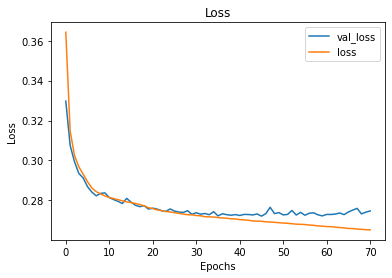

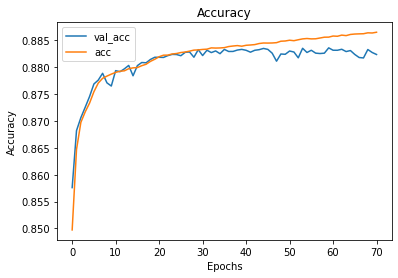

In [396]:
visualize_training_results(base_result_3)

In [192]:
#base 4 we increased batch size to 300 and reduced starting input nodes to 120 and proceeding nodes in each layer by half
#inreased accuracy to 83 (highest), but our valid accuracy is never at or above our training data
base4 = models.Sequential()
base4.add(layers.Dense(120, input_dim=83, activation='relu'))
base4.add(layers.Dense(60, activation='relu'))
base4.add(layers.Dense(30, activation='relu'))
base4.add(layers.Dense(15, activation='relu'))
base4.add(layers.Dense(8, activation='relu'))
base4.add(layers.Dense(4, activation='relu'))
base4.add(layers.Dense(2, activation='relu'))
base4.add(layers.Dense(2, activation='relu'))
base4.add(layers.Dense(1, activation='sigmoid'))


# compile model
base4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [193]:
base_result_4 = base4.fit(x_train_final[no_recover],y_train_final,
                               epochs=250,batch_size=150,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/250
7588/7588 [==============================] - 12s 2ms/step - loss: 0.3440 - acc: 0.8586 - val_loss: 0.3128 - val_acc: 0.8711
Epoch 2/250
7588/7588 [==============================] - 11s 1ms/step - loss: 0.3100 - acc: 0.8727 - val_loss: 0.3096 - val_acc: 0.8727
Epoch 3/250
7588/7588 [==============================] - 10s 1ms/step - loss: 0.3056 - acc: 0.8750 - val_loss: 0.3029 - val_acc: 0.8770
Epoch 4/250
7588/7588 [==============================] - 10s 1ms/step - loss: 0.3021 - acc: 0.8771 - val_loss: 0.3000 - val_acc: 0.8783
Epoch 5/250
7588/7588 [==============================] - 10s 1ms/step - loss: 0.2996 - acc: 0.8784 - val_loss: 0.2990 - val_acc: 0.8789
Epoch 6/250
7588/7588 [==============================] - 10s 1ms/step - loss: 0.2981 - acc: 0.8793 - val_loss: 0.2980 - val_acc: 0.8794
Epoch 7/250
7588/7588 [==============================] - 10s 1ms/step - loss: 0.2969 - acc: 0.8798 - val_loss: 0.2954 - val_acc: 0.8810
Epoch 8/250
7588/7588 [=========================

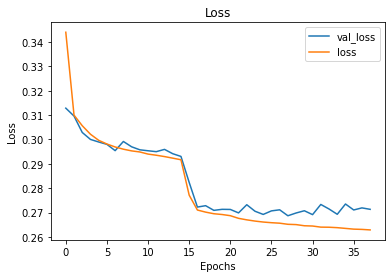

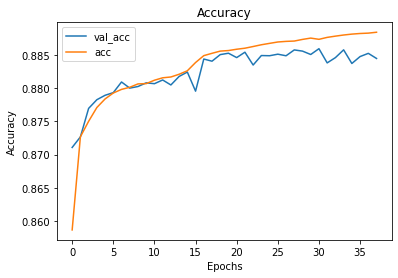

In [198]:
visualize_training_results_acc(base_result_4)

In [199]:
test_class_report('best_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 18s 513us/step - loss: 0.2624 - acc: 0.8885
Training Loss: 0.262 
Training Accuracy: 0.889
----------
13643/13643 [==============================] - 11s 823us/step - loss: 0.4197 - acc: 0.8243
Test Loss: 0.42 
Test Accuracy: 0.824
[[346276  10270]
 [ 66450  13567]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    356546
           1       0.57      0.17      0.26     80017

    accuracy                           0.82    436563
   macro avg       0.70      0.57      0.58    436563
weighted avg       0.79      0.82      0.78    436563



In [213]:
#base 5 dropped 1 layer at end
base5 = models.Sequential()
base5.add(layers.Dense(300, input_dim=83, activation='relu'))
base5.add(layers.Dense(75, activation='relu'))
base5.add(layers.Dense(30, activation='relu'))
base5.add(layers.Dense(15, activation='relu'))
base5.add(layers.Dense(8, activation='relu'))
base5.add(layers.Dense(4, activation='relu'))
base5.add(layers.Dense(2, activation='relu'))
base5.add(layers.Dense(1, activation='sigmoid'))


# compile model
base5.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=.001), metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [214]:
base_result_5 = base5.fit(x_train_final[no_recover],y_train_final,
                               epochs=250,batch_size=150,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/250
7588/7588 [==============================] - 12s 2ms/step - loss: 0.3110 - acc: 0.8624 - val_loss: 0.2886 - val_acc: 0.8754
Epoch 2/250
7588/7588 [==============================] - 13s 2ms/step - loss: 0.2870 - acc: 0.8755 - val_loss: 0.2839 - val_acc: 0.8781
Epoch 3/250
7588/7588 [==============================] - 13s 2ms/step - loss: 0.2821 - acc: 0.8781 - val_loss: 0.2850 - val_acc: 0.8756
Epoch 4/250
7588/7588 [==============================] - 13s 2ms/step - loss: 0.2789 - acc: 0.8798 - val_loss: 0.2767 - val_acc: 0.8806
Epoch 5/250
7588/7588 [==============================] - 13s 2ms/step - loss: 0.2769 - acc: 0.8808 - val_loss: 0.2753 - val_acc: 0.8815
Epoch 6/250
7588/7588 [==============================] - 13s 2ms/step - loss: 0.2753 - acc: 0.8818 - val_loss: 0.2757 - val_acc: 0.8815
Epoch 7/250
7588/7588 [==============================] - 13s 2ms/step - loss: 0.2741 - acc: 0.8822 - val_loss: 0.2732 - val_acc: 0.8829
Epoch 8/250
7588/7588 [=========================

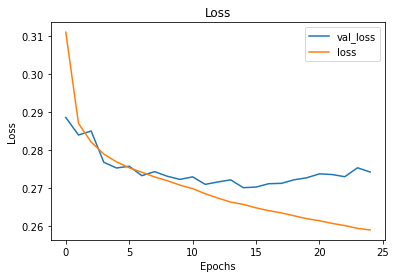

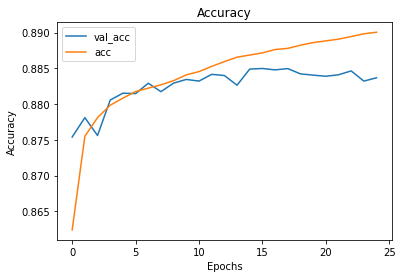

In [215]:
visualize_training_results_acc(base_result_5)

In [216]:
test_class_report('best_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 21s 584us/step - loss: 0.2625 - acc: 0.8886
Training Loss: 0.263 
Training Accuracy: 0.889
----------
13643/13643 [==============================] - 12s 871us/step - loss: 0.4209 - acc: 0.8234
Test Loss: 0.421 
Test Accuracy: 0.823
[[345703  10843]
 [ 66234  13783]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    356546
           1       0.56      0.17      0.26     80017

    accuracy                           0.82    436563
   macro avg       0.70      0.57      0.58    436563
weighted avg       0.79      0.82      0.78    436563



## Dropout

In [75]:
x_train_final[no_recover].shape[1]

83

In [217]:
dropout = models.Sequential()
dropout.add(layers.Dense(120,activation='tanh'))
dropout.add(layers.Dropout(.2))
dropout.add(layers.Dense(60,activation='tanh'))
dropout.add(layers.Dropout(.2))
dropout.add(layers.Dense(30,activation='tanh'))
dropout.add(layers.Dropout(.15))
dropout.add(layers.Dense(15,activation='tanh'))
dropout.add(layers.Dropout(.15))
dropout.add(layers.Dense(1,activation='sigmoid'))

In [218]:
dropout.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_drop_model.h5', monitor='val_loss', save_best_only=True)]

In [219]:
results_drop = dropout.fit(x_train_final[no_recover],y_train_final,
                               epochs=200,batch_size=150,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/200
7588/7588 [==============================] - 17s 2ms/step - loss: 0.3444 - acc: 0.8447 - val_loss: 0.3105 - val_acc: 0.8643
Epoch 2/200
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3195 - acc: 0.8601 - val_loss: 0.3040 - val_acc: 0.8663
Epoch 3/200
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3131 - acc: 0.8637 - val_loss: 0.2959 - val_acc: 0.8721
Epoch 4/200
7588/7588 [==============================] - 16s 2ms/step - loss: 0.3092 - acc: 0.8657 - val_loss: 0.2946 - val_acc: 0.8725
Epoch 5/200
7588/7588 [==============================] - 17s 2ms/step - loss: 0.3071 - acc: 0.8670 - val_loss: 0.2932 - val_acc: 0.8728
Epoch 6/200
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3059 - acc: 0.8677 - val_loss: 0.2933 - val_acc: 0.8727
Epoch 7/200
7588/7588 [==============================] - 19s 2ms/step - loss: 0.3046 - acc: 0.8682 - val_loss: 0.2912 - val_acc: 0.8738
Epoch 8/200
7588/7588 [=========================

Epoch 61/200
7588/7588 [==============================] - 19s 2ms/step - loss: 0.2920 - acc: 0.8749 - val_loss: 0.2800 - val_acc: 0.8796
Epoch 62/200
7588/7588 [==============================] - 17s 2ms/step - loss: 0.2919 - acc: 0.8752 - val_loss: 0.2820 - val_acc: 0.8791
Epoch 63/200
7588/7588 [==============================] - 16s 2ms/step - loss: 0.2918 - acc: 0.8752 - val_loss: 0.2798 - val_acc: 0.8800
Epoch 64/200
7588/7588 [==============================] - 16s 2ms/step - loss: 0.2919 - acc: 0.8753 - val_loss: 0.2794 - val_acc: 0.8797
Epoch 65/200
7588/7588 [==============================] - 16s 2ms/step - loss: 0.2914 - acc: 0.8754 - val_loss: 0.2804 - val_acc: 0.8792
Epoch 66/200
7588/7588 [==============================] - 17s 2ms/step - loss: 0.2917 - acc: 0.8754 - val_loss: 0.2793 - val_acc: 0.8799
Epoch 67/200
7588/7588 [==============================] - 16s 2ms/step - loss: 0.2915 - acc: 0.8754 - val_loss: 0.2790 - val_acc: 0.8800
Epoch 68/200
7588/7588 [=================

In [220]:
test_class_report('best_drop_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 18s 502us/step - loss: 0.2774 - acc: 0.8814
Training Loss: 0.277 
Training Accuracy: 0.881
----------
13643/13643 [==============================] - 11s 837us/step - loss: 0.4235 - acc: 0.8230
Test Loss: 0.423 
Test Accuracy: 0.823
[[346624   9922]
 [ 67332  12685]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    356546
           1       0.56      0.16      0.25     80017

    accuracy                           0.82    436563
   macro avg       0.70      0.57      0.57    436563
weighted avg       0.79      0.82      0.78    436563



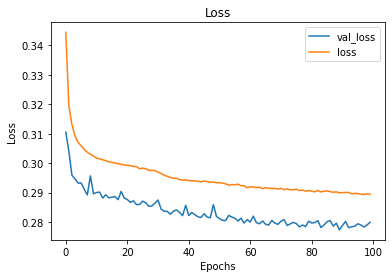

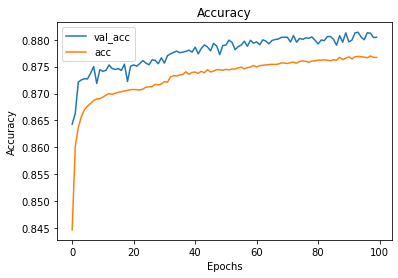

In [222]:
visualize_training_results_acc(results_drop)

In [ ]:

# fit model with given number of nodes, returns test set accuracy
def evaluate__drop_model(n_layers, trainX, trainy, testX, testy,xval,yval,feature):
# configure the model based on the data
    n_input, n_classes = trainX[feature].shape[1], 1
    # define model
    nodes=120
    model = models.Sequential()
    model.add(layers.Dense(nodes, input_dim=n_input, activation='relu'))
    for _ in range(1, n_layers):
        nodes = nodes/2 
        model.add(layers.Dense(nodes, activation='relu'))
        model.add(layers.Dropout(.1))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model on train set
    early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    history = model.fit(trainX[feature], trainy, epochs=250,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval[feature],yval))
    # evaluate model on test set
    saved= load_model('best_model.h5')
    _, test_acc = saved.evaluate(testX[feature], testy, verbose=1)
    return history, test_acc

Epoch 1/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3846 - acc: 0.8174 - val_loss: 0.3630 - val_acc: 0.8300
Epoch 2/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3618 - acc: 0.8306 - val_loss: 0.3556 - val_acc: 0.8344
Epoch 3/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3536 - acc: 0.8359 - val_loss: 0.3454 - val_acc: 0.8405
Epoch 4/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3444 - acc: 0.8408 - val_loss: 0.3444 - val_acc: 0.8394
Epoch 5/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3405 - acc: 0.8427 - val_loss: 0.3419 - val_acc: 0.8413
Epoch 6/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3381 - acc: 0.8439 - val_loss: 0.3353 - val_acc: 0.8451
Epoch 7/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3364 - acc: 0.8451 - val_loss: 0.3341 - val_acc: 0.8459
Epoch 8/100
5358/5358 [=========================

Epoch 18/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3223 - acc: 0.8534 - val_loss: 0.3220 - val_acc: 0.8539
Epoch 19/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3215 - acc: 0.8539 - val_loss: 0.3190 - val_acc: 0.8554
Epoch 20/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3208 - acc: 0.8544 - val_loss: 0.3218 - val_acc: 0.8529
Epoch 21/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3205 - acc: 0.8547 - val_loss: 0.3223 - val_acc: 0.8530
Epoch 22/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3200 - acc: 0.8548 - val_loss: 0.3197 - val_acc: 0.8547
Epoch 23/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3196 - acc: 0.8551 - val_loss: 0.3205 - val_acc: 0.8542
Epoch 24/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3190 - acc: 0.8554 - val_loss: 0.3175 - val_acc: 0.8560
Epoch 25/100
5358/5358 [=================

5358/5358 [==============================] - 12s 2ms/step - loss: 0.3226 - acc: 0.8533 - val_loss: 0.3207 - val_acc: 0.8519
Epoch 18/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3208 - acc: 0.8543 - val_loss: 0.3216 - val_acc: 0.8551
Epoch 19/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3419 - acc: 0.8441 - val_loss: 0.3250 - val_acc: 0.8528
Epoch 20/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3200 - acc: 0.8552 - val_loss: 0.3170 - val_acc: 0.8565
Epoch 21/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3187 - acc: 0.8559 - val_loss: 0.3186 - val_acc: 0.8545
Epoch 22/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3177 - acc: 0.8563 - val_loss: 0.3228 - val_acc: 0.8536
Epoch 23/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3176 - acc: 0.8563 - val_loss: 0.3153 - val_acc: 0.8575
Epoch 24/100
5358/5358 [==============================

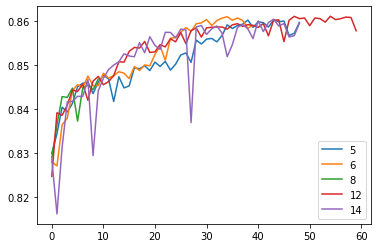

In [154]:
# evaluate model and plot learning curve of model with given number of layers
all_history = list()
num_layers = [5,6,8,12,14]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)    
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['val_acc'], label=str(n_layers))
plt.legend()
plt.show()

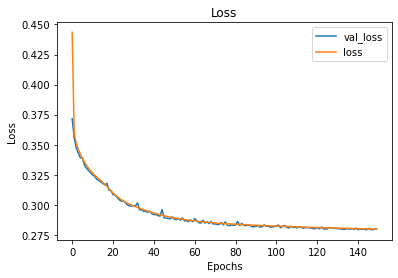

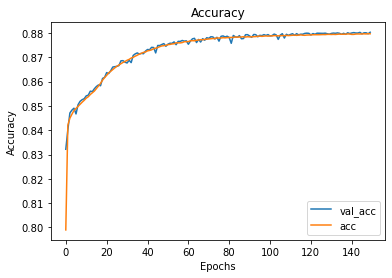

In [52]:
visualize_training_results(base_result)

In [79]:
test_class_report('best_drop_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 24s 668us/step - loss: 0.3638 - acc: 0.8447
Training Loss: 0.364 
Training Accuracy: 0.845
----------
13643/13643 [==============================] - 14s 1ms/step - loss: 0.4673 - acc: 0.7940
Test Loss: 0.467 
Test Accuracy: 0.794
[[320939  35607]
 [ 54309  25708]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88    356546
           1       0.42      0.32      0.36     80017

    accuracy                           0.79    436563
   macro avg       0.64      0.61      0.62    436563
weighted avg       0.78      0.79      0.78    436563



In [180]:

# fit model with given number of nodes, returns test set accuracy
def evaluate_drop_model(n_layers, trainX, trainy, testX, testy,xval,yval):
# configure the model based on the data
    n_input, n_classes = trainX.shape[1], 1
    # define model
    model = models.Sequential()
    model.add(layers.Dense(50, input_dim=n_input, activation='tanh'))
    for _ in range(1, n_lays):
        model.add(layers.Dropout(0.1))
        model.add(layers.Dense(25, activation='tanh'))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train setzz
    early_stopping = [EarlyStopping(monitor='val_acc', patience=15), 
                  ModelCheckpoint(filepath='best_drop_model.h5', monitor='val_acc', save_best_only=True)]
    
    history = model.fit(trainX, trainy, epochs=250,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval,yval))
    # evaluate model on test set
    saved= load_model('best_drop_model.h5')
    _, test_acc = saved.evaluate(testX, testy, verbose=1)
    return history, test_acc

In [175]:
# evaluate model and plot learning curve of model with given number of layers
num_layers = [5,6,7,8,12,]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_drop_model(n_layers, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)    
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['val_acc'], label=str(n_layers))
plt.legend()
plt.show()

Epoch 1/250
  38/5358 [..............................] - ETA: 14s - loss: 0.6123 - acc: 0.6606

KeyboardInterrupt: 

## L2 Regularization

In [152]:

# fit model with given number of nodes, returns test set accuracy
def evaluate_L2_model(n_layers, trainX, trainy, testX, testy,xval,yval,features):
# configure the model based on the data
    n_input, n_classes = trainX[features].shape[1], 1
    # define model
    nodes = 250
    model = models.Sequential()
    model.add(layers.Dense(nodes, input_dim=n_input, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    for x in range(1, n_layers):
        nodes = (nodes/x+1)
        model.add(layers.Dense(nodes, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train set
    early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_l1_model.h5', monitor='val_loss', save_best_only=True)]
    
    history = model.fit(trainX[features], trainy, epochs=200,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval[features],yval))
    # evaluate model on test set
    saved= load_model('best_l1_model.h5')
    _, test_acc = saved.evaluate(testX[features], testy, verbose=1)
    return history, test_acc

First going to see if L2 regularization with same number of layers improves our baseline performance on our validation and test set

In [144]:
l2kr = regularizers.l2(.01)
L2_mod_1 = models.Sequential()
L2_mod_1.add(layers.Dense(120, input_dim=83, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(60, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(30, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(15, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(8, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(4, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(2, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(2, activation='tanh',kernel_regularizer=l2kr))
L2_mod_1.add(layers.Dense(1, activation='sigmoid'))

In [146]:
L2_mod_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_l2_model.h5', monitor='val_loss', save_best_only=True)]

In [147]:
L2_result = L2_mod_1.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=150, 
                            batch_size=150, 
                            validation_data=(x_val[no_recover], y_val))

Epoch 1/150
4446/4446 [==============================] - 11s 2ms/step - loss: 0.5158 - accuracy: 0.8385 - val_loss: 0.4799 - val_accuracy: 0.8428
Epoch 2/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4758 - accuracy: 0.8406 - val_loss: 0.4721 - val_accuracy: 0.8446
Epoch 3/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4670 - accuracy: 0.8407 - val_loss: 0.4631 - val_accuracy: 0.8377
Epoch 4/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4610 - accuracy: 0.8411 - val_loss: 0.4561 - val_accuracy: 0.8437
Epoch 5/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4566 - accuracy: 0.8410 - val_loss: 0.4524 - val_accuracy: 0.8417
Epoch 6/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4532 - accuracy: 0.8412 - val_loss: 0.4505 - val_accuracy: 0.8439
Epoch 7/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4505 - accuracy: 0.8413 - val_loss: 0.4470 - 

Epoch 57/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4197 - accuracy: 0.8420 - val_loss: 0.4178 - val_accuracy: 0.8443
Epoch 58/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4195 - accuracy: 0.8419 - val_loss: 0.4173 - val_accuracy: 0.8432
Epoch 59/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4192 - accuracy: 0.8419 - val_loss: 0.4197 - val_accuracy: 0.8464
Epoch 60/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4192 - accuracy: 0.8421 - val_loss: 0.4167 - val_accuracy: 0.8448
Epoch 61/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4190 - accuracy: 0.8420 - val_loss: 0.4226 - val_accuracy: 0.8457
Epoch 62/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4188 - accuracy: 0.8421 - val_loss: 0.4166 - val_accuracy: 0.8445
Epoch 63/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4186 - accuracy: 0.8420 - val_loss: 0.4161

Epoch 113/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4123 - accuracy: 0.8423 - val_loss: 0.4113 - val_accuracy: 0.8457
Epoch 114/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4125 - accuracy: 0.8418 - val_loss: 0.4130 - val_accuracy: 0.8373
Epoch 115/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4124 - accuracy: 0.8422 - val_loss: 0.4111 - val_accuracy: 0.8456
Epoch 116/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.4122 - accuracy: 0.8419 - val_loss: 0.4100 - val_accuracy: 0.8456
Epoch 117/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4122 - accuracy: 0.8422 - val_loss: 0.4122 - val_accuracy: 0.8460
Epoch 118/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4122 - accuracy: 0.8419 - val_loss: 0.4123 - val_accuracy: 0.8461
Epoch 119/150
4446/4446 [==============================] - 10s 2ms/step - loss: 0.4123 - accuracy: 0.8420 - val_los

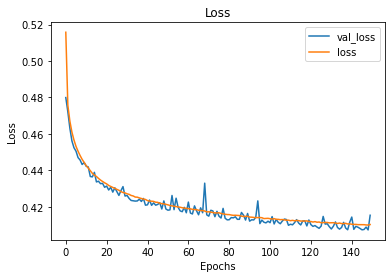

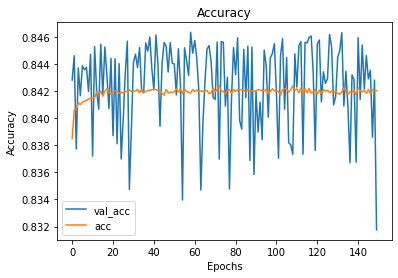

In [148]:
visualize_training_results(L2_result)

In [151]:
train = L2_result.model.evaluate(x_train_final[no_recover],y_train_final)
print(f'Training Loss: {train[0]:.3} \nTraining Accuracy: {train[1]:.3}')
print('----------')
test = L2_result.model.evaluate(x_test_scaled[no_recover],y_test)
print(f'Test Loss: {test[0]:.3} \nTest Accuracy: {test[1]:.3}')
preds = L2_result.model.predict_classes(x_test_scaled[no_recover])
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

35567/35567 [==============================] - 34s 955us/step - loss: 0.4153 - accuracy: 0.8322
Training Loss: 0.415 
Training Accuracy: 0.832
----------
13643/13643 [==============================] - 13s 917us/step - loss: 0.5592 - accuracy: 0.7633
Test Loss: 0.559 
Test Accuracy: 0.763
[[305002  51544]
 [ 51798  28219]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86    356546
           1       0.35      0.35      0.35     80017

    accuracy                           0.76    436563
   macro avg       0.60      0.60      0.60    436563
weighted avg       0.76      0.76      0.76    436563



In [83]:
kr = regularizers.l2(0.01)
opt = Adam(learning_rate=.001)
L2_model = models.Sequential()
L2_model.add(layers.Dense(150, activation='relu', kernel_regularizer=kr, input_shape=(x_train_final[no_recover].shape[1],)))
# Add another hidden layer
L2_model.add(layers.Dense(50, kernel_regularizer=kr, activation='relu'))
L2_model.add(layers.Dense(50, kernel_regularizer=kr, activation='relu'))
# Add an output layer
L2_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
L2_model.compile(optimizer=opt, 
                 loss='binary_crossentropy', 
                 metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_l2_model.h5', monitor='val_loss', save_best_only=True)]

# Train the model 
L2_results = L2_model.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(x_val[no_recover], y_val))

Epoch 1/150
4446/4446 [==============================] - 8s 2ms/step - loss: 0.4762 - acc: 0.8366 - val_loss: 0.4078 - val_acc: 0.8490
Epoch 2/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3988 - acc: 0.8519 - val_loss: 0.3921 - val_acc: 0.8546
Epoch 3/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3852 - acc: 0.8562 - val_loss: 0.3807 - val_acc: 0.8580
Epoch 4/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3786 - acc: 0.8572 - val_loss: 0.3766 - val_acc: 0.8556
Epoch 5/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3737 - acc: 0.8587 - val_loss: 0.3742 - val_acc: 0.8569
Epoch 6/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3699 - acc: 0.8593 - val_loss: 0.3673 - val_acc: 0.8605
Epoch 7/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3672 - acc: 0.8598 - val_loss: 0.3643 - val_acc: 0.8598
Epoch 8/150
4446/4446 [==============================] 

4446/4446 [==============================] - 7s 2ms/step - loss: 0.3341 - acc: 0.8643 - val_loss: 0.3608 - val_acc: 0.8523
Epoch 122/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3338 - acc: 0.8644 - val_loss: 0.3314 - val_acc: 0.8657
Epoch 123/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3338 - acc: 0.8645 - val_loss: 0.3322 - val_acc: 0.8642
Epoch 124/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3341 - acc: 0.8643 - val_loss: 0.3310 - val_acc: 0.8654
Epoch 125/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3338 - acc: 0.8646 - val_loss: 0.3307 - val_acc: 0.8653
Epoch 126/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3338 - acc: 0.8646 - val_loss: 0.3326 - val_acc: 0.8654
Epoch 127/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3333 - acc: 0.8648 - val_loss: 0.3301 - val_acc: 0.8666
Epoch 128/150
4446/4446 [==============================

In [85]:
train = L2_results.model.evaluate(x_train_final[no_recover],y_train_final)
print(f'Training Loss: {train[0]:.3} \nTraining Accuracy: {train[1]:.3}')
print('----------')
test = L2_results.model.evaluate(x_test_scaled[no_recover],y_test)
print(f'Test Loss: {test[0]:.3} \nTest Accuracy: {test[1]:.3}')

35567/35567 [==============================] - 30s 851us/step - loss: 0.3285 - acc: 0.8673
Training Loss: 0.329 
Training Accuracy: 0.867
----------
13643/13643 [==============================] - 11s 830us/step - loss: 0.4636 - acc: 0.8155
Test Loss: 0.464 
Test Accuracy: 0.816


ValueError: in user code:

    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_31 is incompatible with the layer: expected axis -1 of input shape to have value 83 but received input with shape [None, 106]


In [86]:
preds = L2_results.model.predict_classes(x_test_scaled[no_recover])
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[339570  16976]
 [ 63567  16450]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89    356546
           1       0.49      0.21      0.29     80017

    accuracy                           0.82    436563
   macro avg       0.67      0.58      0.59    436563
weighted avg       0.78      0.82      0.78    436563



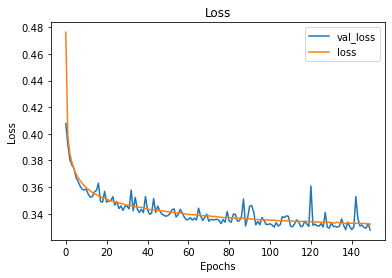

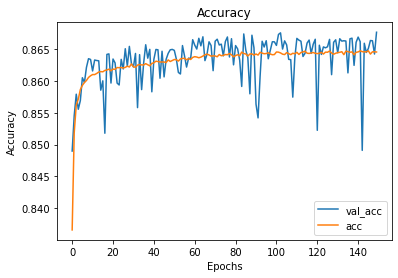

In [90]:
visualize_training_results(L1_results)

## L1 Regularization

In [153]:
l1kr = regularizers.l1(.0001)
L1_mod_1 = models.Sequential()
L1_mod_1.add(layers.Dense(300, input_dim=83, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(125, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(62, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(40, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(20, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(10, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(5, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(3, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(1, activation='sigmoid'))

In [154]:
L1_mod_1.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_l1_model.h5', monitor='val_loss', save_best_only=True)]

# Train the model 
L1_base = L1_mod_1.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=250, 
                            batch_size=300, 
                            validation_data=(x_val[no_recover], y_val),callbacks=early_stopping)

Epoch 1/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.4923 - acc: 0.8425 - val_loss: 0.3896 - val_acc: 0.8448
Epoch 2/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.3810 - acc: 0.8452 - val_loss: 0.3748 - val_acc: 0.8455
Epoch 3/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3722 - acc: 0.8456 - val_loss: 0.3671 - val_acc: 0.8464
Epoch 4/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.3682 - acc: 0.8457 - val_loss: 0.3654 - val_acc: 0.8466
Epoch 5/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.3664 - acc: 0.8457 - val_loss: 0.3642 - val_acc: 0.8460
Epoch 6/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.3650 - acc: 0.8457 - val_loss: 0.3623 - val_acc: 0.8473
Epoch 7/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.3638 - acc: 0.8457 - val_loss: 0.3614 - val_acc: 0.8461
Epoch 8/250
3794/3794 [==============================] 

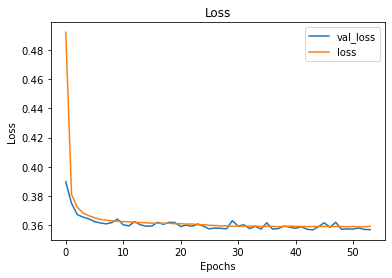

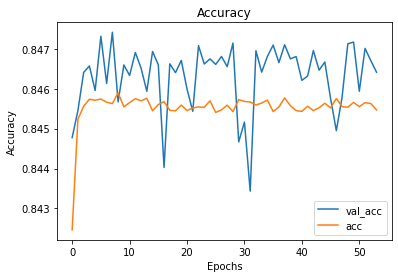

In [157]:
visualize_training_results(L1_base)

In [158]:
test_class_report('best_l1_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 22s 626us/step - loss: 0.3572 - acc: 0.8460
Training Loss: 0.357 
Training Accuracy: 0.846
----------
13643/13643 [==============================] - 14s 991us/step - loss: 0.4783 - acc: 0.8046
Test Loss: 0.478 
Test Accuracy: 0.805
[[337222  19324]
 [ 65992  14025]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89    356546
           1       0.42      0.18      0.25     80017

    accuracy                           0.80    436563
   macro avg       0.63      0.56      0.57    436563
weighted avg       0.76      0.80      0.77    436563



From this test on our baseline model adding L1 regularization we see L1 performs better than L2 so will try to optimize layers and regularization for L1

In [237]:
#reducing regularization to .0001
l1kr = regularizers.l1(.0001)
L1_mod_1 = models.Sequential()
L1_mod_1.add(layers.Dense(300, input_dim=83, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(125, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(62, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(40, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(20, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(10, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(5, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(3, activation='tanh',kernel_regularizer=l1kr))
L1_mod_1.add(layers.Dense(1, activation='sigmoid'))

In [160]:
L1_mod_1.compile(optimizer='sgd', 
                 loss='binary_crossentropy', 
                 metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
                  ModelCheckpoint(filepath='best_l1_model.h5', monitor='val_loss', save_best_only=True)]

# Train the model 
L1_base2 = L1_mod_1.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=250, 
                            batch_size=300, 
                            validation_data=(x_val[no_recover], y_val),callbacks=early_stopping)

Epoch 1/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.8678 - acc: 0.8346 - val_loss: 0.8626 - val_acc: 0.8156
Epoch 2/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.8098 - acc: 0.8463 - val_loss: 0.7964 - val_acc: 0.8461
Epoch 3/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.7783 - acc: 0.8479 - val_loss: 0.7718 - val_acc: 0.8416
Epoch 4/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.7485 - acc: 0.8496 - val_loss: 0.7301 - val_acc: 0.8538
Epoch 5/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.7170 - acc: 0.8549 - val_loss: 0.6987 - val_acc: 0.8602
Epoch 6/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.6907 - acc: 0.8572 - val_loss: 0.6751 - val_acc: 0.8607
Epoch 7/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.6642 - acc: 0.8592 - val_loss: 0.6489 - val_acc: 0.8607
Epoch 8/250
3794/3794 [==============================] 

3794/3794 [==============================] - 8s 2ms/step - loss: 0.3235 - acc: 0.8689 - val_loss: 0.3227 - val_acc: 0.8691
Epoch 62/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3227 - acc: 0.8690 - val_loss: 0.3225 - val_acc: 0.8685
Epoch 63/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3222 - acc: 0.8689 - val_loss: 0.3196 - val_acc: 0.8701
Epoch 64/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3214 - acc: 0.8692 - val_loss: 0.3236 - val_acc: 0.8682
Epoch 65/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3208 - acc: 0.8692 - val_loss: 0.3179 - val_acc: 0.8708
Epoch 66/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3204 - acc: 0.8694 - val_loss: 0.3179 - val_acc: 0.8709
Epoch 67/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3198 - acc: 0.8693 - val_loss: 0.3178 - val_acc: 0.8699
Epoch 68/250
3794/3794 [==============================] - 8s 

3794/3794 [==============================] - 9s 2ms/step - loss: 0.3082 - acc: 0.8716 - val_loss: 0.3139 - val_acc: 0.8682
Epoch 122/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3082 - acc: 0.8716 - val_loss: 0.3070 - val_acc: 0.8722
Epoch 123/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3102 - acc: 0.8706 - val_loss: 0.3062 - val_acc: 0.8727
Epoch 124/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3084 - acc: 0.8715 - val_loss: 0.3066 - val_acc: 0.8728
Epoch 125/250
3794/3794 [==============================] - 10s 3ms/step - loss: 0.3080 - acc: 0.8716 - val_loss: 0.3066 - val_acc: 0.8721
Epoch 126/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3110 - acc: 0.8700 - val_loss: 0.3115 - val_acc: 0.8685
Epoch 127/250
3794/3794 [==============================] - 9s 2ms/step - loss: 0.3088 - acc: 0.8711 - val_loss: 0.3075 - val_acc: 0.8719
Epoch 128/250
3794/3794 [=============================

Epoch 181/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3047 - acc: 0.8722 - val_loss: 0.3024 - val_acc: 0.8734
Epoch 182/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3168 - acc: 0.8678 - val_loss: 0.3026 - val_acc: 0.8732
Epoch 183/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3045 - acc: 0.8724 - val_loss: 0.3073 - val_acc: 0.8705
Epoch 184/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3045 - acc: 0.8723 - val_loss: 0.3038 - val_acc: 0.8724
Epoch 185/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3092 - acc: 0.8703 - val_loss: 0.3081 - val_acc: 0.8689
Epoch 186/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3051 - acc: 0.8718 - val_loss: 0.3059 - val_acc: 0.8726
Epoch 187/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3095 - acc: 0.8701 - val_loss: 0.3160 - val_acc: 0.8670
Epoch 188/250
3794/3794 [================

Epoch 241/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3027 - acc: 0.8728 - val_loss: 0.3005 - val_acc: 0.8738
Epoch 242/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3024 - acc: 0.8730 - val_loss: 0.3021 - val_acc: 0.8729
Epoch 243/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3045 - acc: 0.8721 - val_loss: 0.3008 - val_acc: 0.8737
Epoch 244/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3030 - acc: 0.8728 - val_loss: 0.3013 - val_acc: 0.8729
Epoch 245/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3025 - acc: 0.8729 - val_loss: 0.2995 - val_acc: 0.8743
Epoch 246/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3027 - acc: 0.8727 - val_loss: 0.3005 - val_acc: 0.8738
Epoch 247/250
3794/3794 [==============================] - 8s 2ms/step - loss: 0.3132 - acc: 0.8690 - val_loss: 0.3047 - val_acc: 0.8721
Epoch 248/250
3794/3794 [================

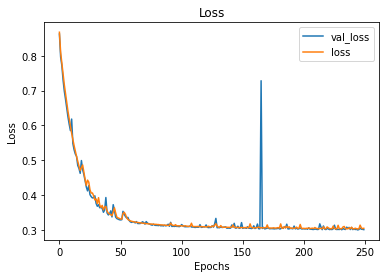

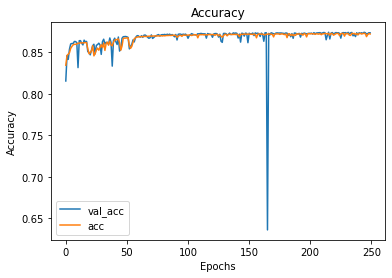

In [162]:
visualize_training_results(L1_base2)

In [163]:
train = L1_base2.model.evaluate(x_train_final[no_recover],y_train_final)
print(f'Training Loss: {train[0]:.3} \nTraining Accuracy: {train[1]:.3}')
print('----------')
test = L1_base2.model.evaluate(x_test_scaled[no_recover],y_test)
print(f'Test Loss: {test[0]:.3} \nTest Accuracy: {test[1]:.3}')
preds = L1_base2.model.predict_classes(x_test_scaled[no_recover])
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

35567/35567 [==============================] - 32s 905us/step - loss: 0.3011 - acc: 0.8736
Training Loss: 0.301 
Training Accuracy: 0.874
----------
13643/13643 [==============================] - 12s 912us/step - loss: 0.4420 - acc: 0.8190
Test Loss: 0.442 
Test Accuracy: 0.819
[[343699  12847]
 [ 66172  13845]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90    356546
           1       0.52      0.17      0.26     80017

    accuracy                           0.82    436563
   macro avg       0.68      0.57      0.58    436563
weighted avg       0.78      0.82      0.78    436563



Notably, by changing our penalty coefficient to .0001 from .001 we were able to increase accuracy by .02% 

### L1 with Drop

In [240]:
#reducing regularization to .0001
l1kr = regularizers.l1(.0001)
L1_drop = models.Sequential()
L1_drop.add(layers.Dense(120, input_dim=83, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dropout(.25))
L1_drop.add(layers.Dense(60, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dropout(.25))
L1_drop.add(layers.Dense(30, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dropout(.25))
L1_drop.add(layers.Dense(15, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dropout(.25))
L1_drop.add(layers.Dense(8, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dropout(.25))
L1_drop.add(layers.Dense(4, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dropout(.20))
L1_drop.add(layers.Dense(2, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dropout(.20))
L1_drop.add(layers.Dense(2, activation='tanh',kernel_regularizer=l1kr))
L1_drop.add(layers.Dense(1, activation='sigmoid'))

In [241]:
L1_drop.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
                  ModelCheckpoint(filepath='best_l1_drop_model.h5', monitor='val_loss', save_best_only=True)]

In [227]:
L1_drop_results = L1_drop.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=250, 
                            batch_size=150, 
                            validation_data=(x_val[no_recover], y_val),callbacks=early_stopping)

Epoch 1/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.4742 - acc: 0.8229 - val_loss: 0.3873 - val_acc: 0.8461
Epoch 2/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.4051 - acc: 0.8292 - val_loss: 0.3780 - val_acc: 0.8474
Epoch 3/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.4000 - acc: 0.8297 - val_loss: 0.3742 - val_acc: 0.8450
Epoch 4/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3977 - acc: 0.8297 - val_loss: 0.3750 - val_acc: 0.8455
Epoch 5/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3973 - acc: 0.8298 - val_loss: 0.3768 - val_acc: 0.8431
Epoch 6/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3969 - acc: 0.8300 - val_loss: 0.3735 - val_acc: 0.8473
Epoch 7/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3969 - acc: 0.8297 - val_loss: 0.3741 - val_acc: 0.8474
Epoch 8/250
7588/7588 [=========================

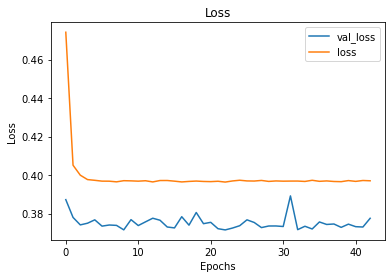

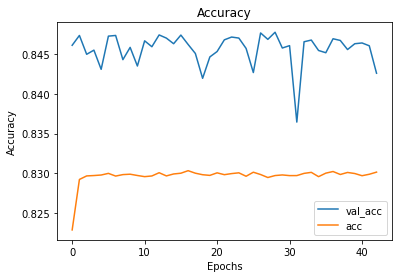

In [229]:
visualize_training_results_acc(L1_drop_results)

In [231]:
test_class_report('best_l1_drop_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 24s 672us/step - loss: 0.3721 - acc: 0.8467
Training Loss: 0.372 
Training Accuracy: 0.847
----------
13643/13643 [==============================] - 13s 972us/step - loss: 0.4983 - acc: 0.8141
Test Loss: 0.498 
Test Accuracy: 0.814
[[345671  10875]
 [ 70289   9728]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    356546
           1       0.47      0.12      0.19     80017

    accuracy                           0.81    436563
   macro avg       0.65      0.55      0.54    436563
weighted avg       0.77      0.81      0.77    436563



In [242]:
from tensorflow.keras.constraints import max_norm

In [277]:
#reducing regularization to .0001
l1kr = regularizers.l1(.00001)
L1_drop1 = models.Sequential()

L1_drop1.add(layers.Dense(100, input_dim=83, activation='relu',kernel_regularizer=l1kr))
L1_drop1.add(layers.Dropout(.2))
L1_drop1.add(layers.Dense(60, activation='relu',kernel_regularizer=l1kr))
L1_drop1.add(layers.Dropout(.2))
L1_drop1.add(layers.Dense(30, activation='relu',kernel_regularizer=l1kr))
L1_drop1.add(layers.Dropout(.2))
L1_drop1.add(layers.Dense(15, activation='relu',kernel_regularizer=l1kr))
L1_drop1.add(layers.Dropout(.2))
L1_drop1.add(layers.Dense(8, activation='relu',kernel_regularizer=l1kr))
L1_drop1.add(layers.Dropout(.15))
L1_drop1.add(layers.Dense(4, activation='relu',kernel_regularizer=l1kr))
L1_drop1.add(layers.Dropout(.15))
L1_drop1.add(layers.Dense(2, activation='relu',kernel_regularizer=l1kr))
L1_drop1.add(layers.Dropout(.15))
L1_drop1.add(layers.Dense(1, activation='sigmoid'))

In [278]:
L1_drop1.compile(optimizer=optimizers.Adam(learning_rate=.01,), 
                 loss='binary_crossentropy', 
                 metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
                  ModelCheckpoint(filepath='best_l1_drop_model.h5', monitor='val_loss', save_best_only=True)]

In [279]:
L1_drop_results1 = L1_drop1.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=250, 
                            batch_size=150, 
                            validation_data=(x_val[no_recover], y_val),callbacks=early_stopping)

Epoch 1/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.4831 - acc: 0.7743 - val_loss: 0.4151 - val_acc: 0.8500
Epoch 2/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.4684 - acc: 0.7834 - val_loss: 0.3971 - val_acc: 0.8539
Epoch 3/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.4647 - acc: 0.7866 - val_loss: 0.3902 - val_acc: 0.8518
Epoch 4/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.4611 - acc: 0.7884 - val_loss: 0.3811 - val_acc: 0.8571
Epoch 5/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.4590 - acc: 0.7891 - val_loss: 0.3795 - val_acc: 0.8568
Epoch 6/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.4603 - acc: 0.7887 - val_loss: 0.4017 - val_acc: 0.8561
Epoch 7/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.4575 - acc: 0.7914 - val_loss: 0.3793 - val_acc: 0.8603
Epoch 8/250
7588/7588 [=========================

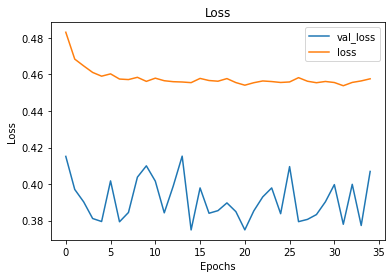

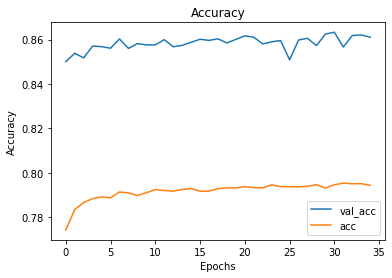

In [280]:
visualize_training_results_acc(L1_drop_results1)

In [281]:
test_class_report('best_l1_drop_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 19s 533us/step - loss: 0.3746 - acc: 0.8593
Training Loss: 0.375 
Training Accuracy: 0.859
----------
13643/13643 [==============================] - 12s 846us/step - loss: 0.4647 - acc: 0.8168
Test Loss: 0.465 
Test Accuracy: 0.817
[[342410  14136]
 [ 65825  14192]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90    356546
           1       0.50      0.18      0.26     80017

    accuracy                           0.82    436563
   macro avg       0.67      0.57      0.58    436563
weighted avg       0.78      0.82      0.78    436563



In [307]:
#reducing regularization to .0001
l2kr = regularizers.l2(.0002)
L2_drop1 = models.Sequential()

L2_drop1.add(layers.Dense(120, input_dim=83, activation='tanh',kernel_regularizer=l2kr))
L2_drop1.add(layers.Dropout(.2))
L2_drop1.add(layers.Dense(60, activation='tanh',kernel_regularizer=l1kr))
L2_drop1.add(layers.Dropout(.2))
L2_drop1.add(layers.Dense(30, activation='tanh',kernel_regularizer=l1kr))
L2_drop1.add(layers.Dropout(.2))
L2_drop1.add(layers.Dense(15, activation='tanh',kernel_regularizer=l1kr))
L2_drop1.add(layers.Dropout(.2))
L2_drop1.add(layers.Dense(8, activation='tanh',kernel_regularizer=l1kr))
L2_drop1.add(layers.Dropout(.15))
L2_drop1.add(layers.Dense(1, activation='sigmoid'))

In [308]:
L2_drop1.compile(optimizer=optimizers.Adam(learning_rate=.001,), 
                 loss='binary_crossentropy', 
                 metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
                  ModelCheckpoint(filepath='best_l2_drop_model.h5', monitor='val_loss', save_best_only=True)]

In [309]:
L2_drop_results = L2_drop1.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=250, 
                            batch_size=150, 
                            validation_data=(x_val[no_recover], y_val),callbacks=early_stopping)

Epoch 1/250
7588/7588 [==============================] - 17s 2ms/step - loss: 0.3808 - acc: 0.8377 - val_loss: 0.3413 - val_acc: 0.8546
Epoch 2/250
7588/7588 [==============================] - 17s 2ms/step - loss: 0.3521 - acc: 0.8491 - val_loss: 0.3327 - val_acc: 0.8584
Epoch 3/250
7588/7588 [==============================] - 17s 2ms/step - loss: 0.3442 - acc: 0.8519 - val_loss: 0.3229 - val_acc: 0.8618
Epoch 4/250
7588/7588 [==============================] - 17s 2ms/step - loss: 0.3413 - acc: 0.8531 - val_loss: 0.3243 - val_acc: 0.8595
Epoch 5/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3401 - acc: 0.8540 - val_loss: 0.3270 - val_acc: 0.8580
Epoch 6/250
7588/7588 [==============================] - 17s 2ms/step - loss: 0.3390 - acc: 0.8541 - val_loss: 0.3211 - val_acc: 0.8621
Epoch 7/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.3384 - acc: 0.8544 - val_loss: 0.3196 - val_acc: 0.8625
Epoch 8/250
7588/7588 [=========================

Epoch 61/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.3333 - acc: 0.8610 - val_loss: 0.3180 - val_acc: 0.8667
Epoch 62/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.3332 - acc: 0.8614 - val_loss: 0.3170 - val_acc: 0.8676
Epoch 63/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.3330 - acc: 0.8613 - val_loss: 0.3125 - val_acc: 0.8689
Epoch 64/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.3329 - acc: 0.8614 - val_loss: 0.3133 - val_acc: 0.8698
Epoch 65/250
7588/7588 [==============================] - 19s 3ms/step - loss: 0.3328 - acc: 0.8615 - val_loss: 0.3118 - val_acc: 0.8708
Epoch 66/250
7588/7588 [==============================] - 19s 2ms/step - loss: 0.3329 - acc: 0.8615 - val_loss: 0.3140 - val_acc: 0.8678
Epoch 67/250
7588/7588 [==============================] - 18s 2ms/step - loss: 0.3330 - acc: 0.8612 - val_loss: 0.3109 - val_acc: 0.8702
Epoch 68/250
7588/7588 [=================

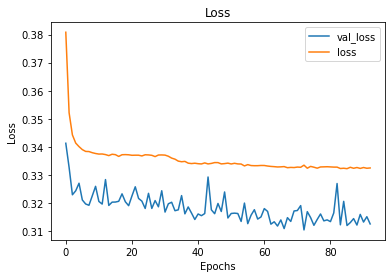

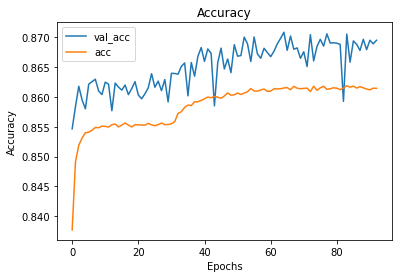

In [310]:
visualize_training_results_acc(L2_drop_results)

In [311]:
test_class_report('best_l2_drop_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 20s 569us/step - loss: 0.3112 - acc: 0.8702
Training Loss: 0.311 
Training Accuracy: 0.87
----------
13643/13643 [==============================] - 11s 831us/step - loss: 0.4485 - acc: 0.8177
Test Loss: 0.448 
Test Accuracy: 0.818
[[342785  13761]
 [ 65808  14209]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90    356546
           1       0.51      0.18      0.26     80017

    accuracy                           0.82    436563
   macro avg       0.67      0.57      0.58    436563
weighted avg       0.78      0.82      0.78    436563



In [397]:
#reducing regularization to .0001
l2kr = regularizers.l2(.0001)
L2_drop2 = models.Sequential()
L2_drop2.add(layers.Dense(100, activation='relu',kernel_regularizer=l2kr))
L2_drop2.add(layers.Dropout(.2))
L2_drop2.add(layers.Dense(50, activation='relu',kernel_regularizer=l1kr))
L2_drop2.add(layers.Dropout(.2))
L2_drop2.add(layers.Dense(25, activation='relu',kernel_regularizer=l1kr))
L2_drop2.add(layers.Dropout(.15))
L2_drop2.add(layers.Dense(12, activation='relu',kernel_regularizer=l1kr))
L2_drop2.add(layers.Dropout(.15))
L2_drop2.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
L2_drop2.compile(optimizer=optimizers.Adam(learning_rate=.0005), 
                 loss='binary_crossentropy', 
                 metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=25), 
                  ModelCheckpoint(filepath='l2_drop_model.h5', monitor='val_loss', save_best_only=True)]

In [384]:
L2_drop_results2 = L2_drop2.fit(x_train_final[no_recover], 
                            y_train_final, 
                            epochs=350, 
                            batch_size=250, 
                            validation_data=(x_val[no_recover], y_val),callbacks=early_stopping)

Epoch 1/350
7588/7588 [==============================] - 29s 4ms/step - loss: 0.3605 - acc: 0.8507 - val_loss: 0.3167 - val_acc: 0.8689
Epoch 2/350
7588/7588 [==============================] - 30s 4ms/step - loss: 0.3156 - acc: 0.8689 - val_loss: 0.3069 - val_acc: 0.8732
Epoch 3/350
7588/7588 [==============================] - 34s 4ms/step - loss: 0.3065 - acc: 0.8726 - val_loss: 0.3017 - val_acc: 0.8741
Epoch 4/350
7588/7588 [==============================] - 28s 4ms/step - loss: 0.3033 - acc: 0.8738 - val_loss: 0.2975 - val_acc: 0.8763
Epoch 5/350
7588/7588 [==============================] - 30s 4ms/step - loss: 0.3014 - acc: 0.8745 - val_loss: 0.2974 - val_acc: 0.8765
Epoch 6/350
7588/7588 [==============================] - 30s 4ms/step - loss: 0.3002 - acc: 0.8749 - val_loss: 0.2968 - val_acc: 0.8761
Epoch 7/350
7588/7588 [==============================] - 27s 4ms/step - loss: 0.2995 - acc: 0.8751 - val_loss: 0.2934 - val_acc: 0.8774
Epoch 8/350
7588/7588 [=========================

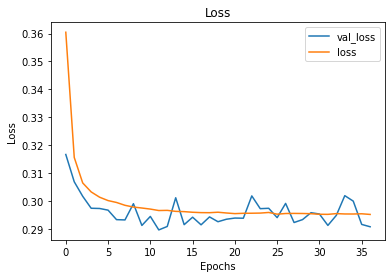

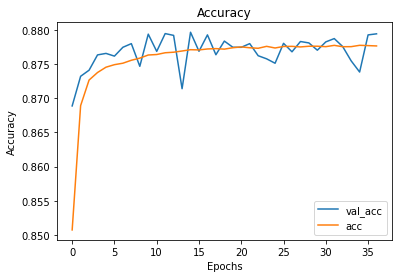

In [385]:
visualize_training_results_acc(L2_drop_results2)

In [386]:
test_class_report('best_l2_drop_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 26s 727us/step - loss: 0.2905 - acc: 0.8790
Training Loss: 0.291 
Training Accuracy: 0.879
----------
13643/13643 [==============================] - 14s 1ms/step - loss: 0.4343 - acc: 0.8231
Test Loss: 0.434 
Test Accuracy: 0.823
[[349756   6790]
 [ 70454   9563]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90    356546
           1       0.58      0.12      0.20     80017

    accuracy                           0.82    436563
   macro avg       0.71      0.55      0.55    436563
weighted avg       0.79      0.82      0.77    436563



In [103]:

# fit model with given number of nodes, returns test set accuracy
def evaluate_L1_model(n_layers, trainX, trainy, testX, testy,xval,yval,features):
# configure the model based on the data
    n_input, n_classes = trainX[features].shape[1], 1
    # define model
    nodes = 300
    model = models.Sequential()
    model.add(layers.Dense(nodes, input_dim=n_input, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
    for _ in range(1, n_layers):
        nodes = nodes/2
        model.add(layers.Dense(nodes, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train set
    early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_l1_model.h5', monitor='val_loss', save_best_only=True)]
    
    history = model.fit(trainX[features], trainy, epochs=150,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval[features],yval))
    # evaluate model on test set
    saved= load_model('best_l1_model.h5')
    _, test_acc = saved.evaluate(testX[features], testy, verbose=1)
    return history, test_acc

Epoch 1/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.4629 - acc: 0.8431 - val_loss: 0.3811 - val_acc: 0.8537
Epoch 2/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3669 - acc: 0.8572 - val_loss: 0.3537 - val_acc: 0.8618
Epoch 3/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3507 - acc: 0.8606 - val_loss: 0.3448 - val_acc: 0.8606
Epoch 4/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3432 - acc: 0.8618 - val_loss: 0.3384 - val_acc: 0.8646
Epoch 5/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3397 - acc: 0.8643 - val_loss: 0.3363 - val_acc: 0.8669
Epoch 6/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3380 - acc: 0.8659 - val_loss: 0.3348 - val_acc: 0.8671
Epoch 7/150
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3369 - acc: 0.8661 - val_loss: 0.3410 - val_acc: 0.8631
Epoch 8/150
4446/4446 [==============================] 

4446/4446 [==============================] - 9s 2ms/step - loss: 0.6964 - acc: 0.4996 - val_loss: 0.6964 - val_acc: 0.4999
Epoch 6/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.6964 - acc: 0.4997 - val_loss: 0.6964 - val_acc: 0.5001
Epoch 7/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.6964 - acc: 0.5002 - val_loss: 0.6964 - val_acc: 0.4999
Epoch 8/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.6964 - acc: 0.5003 - val_loss: 0.6964 - val_acc: 0.5001
Epoch 9/150
4446/4446 [==============================] - 9s 2ms/step - loss: 0.6964 - acc: 0.4993 - val_loss: 0.6964 - val_acc: 0.5001
Epoch 10/150
13643/13643 [==============================] - 7s 504us/step - loss: 0.6932 - acc: 0.8167
layers=7: 0.817


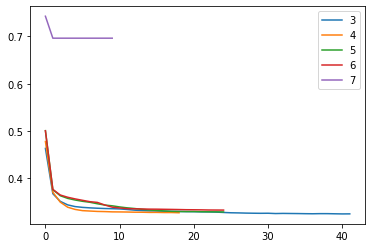

In [104]:
# evaluate model and plot learning curve of model with given number of layers

num_layers = [3,4,5,6,7]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_L1_model_model(n_layers, x_train_final,
                                     y_train_final, x_test_scaled, y_test,
                                     x_val,y_val,no_recover)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [110]:
n_layers = 3
l1 = models.Sequential()
l1.add(layers.Dense(100, input_dim=83, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
for _ in range(1, n_layers):
    l1.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
l1.add(layers.Dense(1, activation='sigmoid'))


# compile model
l1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
              ModelCheckpoint(filepath='best_l1_model.h5', monitor='val_loss', save_best_only=True)]

history = l1.fit(x_train_final[no_recover], y_train_final, epochs=200,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.4620 - acc: 0.8449 - val_loss: 0.3761 - val_acc: 0.8568
Epoch 2/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3645 - acc: 0.8562 - val_loss: 0.3541 - val_acc: 0.8586
Epoch 3/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3521 - acc: 0.8585 - val_loss: 0.3487 - val_acc: 0.8598
Epoch 4/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3460 - acc: 0.8603 - val_loss: 0.3431 - val_acc: 0.8615
Epoch 5/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3416 - acc: 0.8619 - val_loss: 0.3431 - val_acc: 0.8607
Epoch 6/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3379 - acc: 0.8632 - val_loss: 0.3352 - val_acc: 0.8635
Epoch 7/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3348 - acc: 0.8640 - val_loss: 0.3328 - val_acc: 0.8647
Epoch 8/200
4446/4446 [==============================] 

In [111]:
test_class_report('best_l1_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 17s 489us/step - loss: 0.3245 - acc: 0.8672
Training Loss: 0.324 
Training Accuracy: 0.867
----------
13643/13643 [==============================] - 11s 790us/step - loss: 0.4619 - acc: 0.8150
Test Loss: 0.462 
Test Accuracy: 0.815
[[339816  16730]
 [ 64025  15992]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89    356546
           1       0.49      0.20      0.28     80017

    accuracy                           0.82    436563
   macro avg       0.67      0.58      0.59    436563
weighted avg       0.78      0.82      0.78    436563



In [112]:
n_layers = 4
l1 = models.Sequential()
l1.add(layers.Dense(100, input_dim=83, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
for _ in range(1, n_layers):
    l1.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
l1.add(layers.Dense(1, activation='sigmoid'))


# compile model
l1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
              ModelCheckpoint(filepath='best_l1_model.h5', monitor='val_loss', save_best_only=True)]

history = l1.fit(x_train_final[no_recover], y_train_final, epochs=200,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(x_val[no_recover],y_val))

Epoch 1/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.4761 - acc: 0.8433 - val_loss: 0.3762 - val_acc: 0.8555
Epoch 2/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.3658 - acc: 0.8560 - val_loss: 0.3572 - val_acc: 0.8581
Epoch 3/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.3541 - acc: 0.8573 - val_loss: 0.3510 - val_acc: 0.8587
Epoch 4/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.3472 - acc: 0.8578 - val_loss: 0.3465 - val_acc: 0.8572
Epoch 5/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3433 - acc: 0.8584 - val_loss: 0.3387 - val_acc: 0.8607
Epoch 6/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.3405 - acc: 0.8594 - val_loss: 0.3397 - val_acc: 0.8601
Epoch 7/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.3390 - acc: 0.8598 - val_loss: 0.3372 - val_acc: 0.8613
Epoch 8/200
4446/4446 [==============================] 

4446/4446 [==============================] - 7s 2ms/step - loss: 0.3293 - acc: 0.8633 - val_loss: 0.3269 - val_acc: 0.8640
Epoch 122/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3293 - acc: 0.8631 - val_loss: 0.3288 - val_acc: 0.8645
Epoch 123/200
4446/4446 [==============================] - 8s 2ms/step - loss: 0.3293 - acc: 0.8633 - val_loss: 0.3313 - val_acc: 0.8618
Epoch 124/200
4446/4446 [==============================] - 7s 2ms/step - loss: 0.3293 - acc: 0.8632 - val_loss: 0.3267 - val_acc: 0.8644


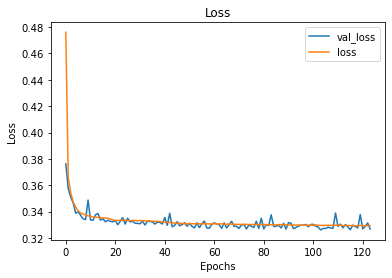

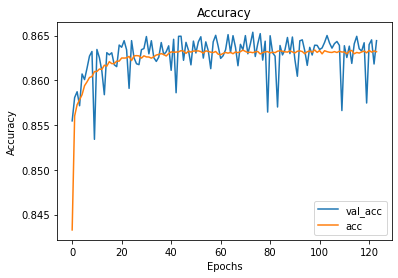

In [114]:
visualize_training_results(history)

In [113]:
test_class_report('best_l1_model.h5',x_test_scaled[no_recover],y_test,x_train_final[no_recover],y_train_final)

35567/35567 [==============================] - 17s 482us/step - loss: 0.3267 - acc: 0.8648
Training Loss: 0.327 
Training Accuracy: 0.865
----------
13643/13643 [==============================] - 12s 870us/step - loss: 0.4564 - acc: 0.8177
Test Loss: 0.456 
Test Accuracy: 0.818
[[341727  14819]
 [ 64757  15260]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90    356546
           1       0.51      0.19      0.28     80017

    accuracy                           0.82    436563
   macro avg       0.67      0.57      0.59    436563
weighted avg       0.78      0.82      0.78    436563



### L1 with Drop

In [ ]:
# evaluate model and plot learning curve of model with given number of layers

num_layers = [3,4,5,6,7]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_L1_model_model(n_layers, x_train_final,
                                     y_train_final, x_test_scaled, y_test,
                                     x_val,y_val,no_recover)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [119]:
# fit model with given number of nodes, returns test set accuracy
def evaluate_l1_drop_model(rate, trainX, trainy, testX, testy,xval,yval):
# configure the model based on the data
    n_input, n_classes = trainX.shape[1], 1
    # define model
    model = models.Sequential()
    model.add(layers.Dense(100, input_dim=n_input, activation='tanh',kernel_regularizer=regularizers.l1(0.001)))
    for _ in range(1, 5):
        model.add(layers.Dropout(rate))
        model.add(layers.Dense(50, activation='tanh',kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train setzz
    early_stopping = [EarlyStopping(monitor='val_acc', patience=10), 
                  ModelCheckpoint(filepath='best_l1_drop_model.h5', monitor='val_acc', save_best_only=True)]
    
    history = model.fit(trainX, trainy, epochs=250,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval,yval))
    # evaluate model on test set
    saved= load_model('best_drop_model.h5')
    _, test_acc = saved.evaluate(testX, testy, verbose=1)
    return history, test_acc

Epoch 1/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.5197 - acc: 0.8370 - val_loss: 0.4092 - val_acc: 0.8413
Epoch 2/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4117 - acc: 0.8439 - val_loss: 0.3981 - val_acc: 0.8456
Epoch 3/250
4446/4446 [==============================] - 14s 3ms/step - loss: 0.4069 - acc: 0.8439 - val_loss: 0.3936 - val_acc: 0.8460
Epoch 4/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4034 - acc: 0.8439 - val_loss: 0.3904 - val_acc: 0.8469
Epoch 5/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4024 - acc: 0.8439 - val_loss: 0.3946 - val_acc: 0.8424
Epoch 6/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4016 - acc: 0.8438 - val_loss: 0.3897 - val_acc: 0.8464
Epoch 7/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4008 - acc: 0.8440 - val_loss: 0.3887 - val_acc: 0.8471
Epoch 8/250
4446/4446 [=========================

Epoch 15/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4491 - acc: 0.8400 - val_loss: 0.4238 - val_acc: 0.8457
Epoch 16/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4494 - acc: 0.8396 - val_loss: 0.4244 - val_acc: 0.8456
Epoch 17/250
4446/4446 [==============================] - 15s 3ms/step - loss: 0.4490 - acc: 0.8397 - val_loss: 0.4240 - val_acc: 0.8452
Epoch 18/250
13643/13643 [==============================] - 9s 643us/step - loss: 0.4673 - acc: 0.7940
layers=0: 0.794


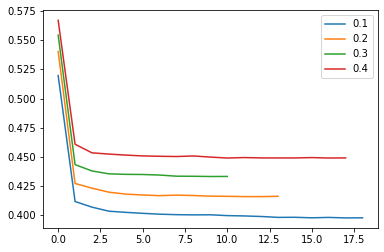

In [120]:
drop_rates = [.1,.2,.3,.4]
for rate in drop_rates:
    # evaluate model with a given number of layers
    history, result = evaluate_l1_drop_model(rate, x_train_final[no_recover],
                                     y_train_final, x_test_scaled[no_recover], y_test,
                                     x_val[no_recover],y_val)
    print('layers=%d: %.3f' % (rate, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(rate))
plt.legend()
plt.show()

## L2 Regularization

Epoch 1/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3874 - acc: 0.8165 - val_loss: 0.3652 - val_acc: 0.8293
Epoch 2/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3631 - acc: 0.8300 - val_loss: 0.3607 - val_acc: 0.8313
Epoch 3/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3569 - acc: 0.8336 - val_loss: 0.3505 - val_acc: 0.8380
Epoch 4/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3487 - acc: 0.8390 - val_loss: 0.3435 - val_acc: 0.8423
Epoch 5/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3423 - acc: 0.8425 - val_loss: 0.3388 - val_acc: 0.8442
Epoch 6/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3390 - acc: 0.8440 - val_loss: 0.3360 - val_acc: 0.8450
Epoch 7/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3371 - acc: 0.8448 - val_loss: 0.3368 - val_acc: 0.8431
Epoch 8/100
5358/5358 [==============================] 

5358/5358 [==============================] - 7s 1ms/step - loss: 0.3135 - acc: 0.8584 - val_loss: 0.3137 - val_acc: 0.8585
Epoch 33/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3124 - acc: 0.8590 - val_loss: 0.3116 - val_acc: 0.8600
Epoch 34/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3120 - acc: 0.8593 - val_loss: 0.3115 - val_acc: 0.8597
Epoch 35/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3113 - acc: 0.8596 - val_loss: 0.3103 - val_acc: 0.8608
Epoch 36/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3110 - acc: 0.8598 - val_loss: 0.3097 - val_acc: 0.8608
Epoch 37/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3104 - acc: 0.8602 - val_loss: 0.3099 - val_acc: 0.8605
Epoch 38/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3103 - acc: 0.8605 - val_loss: 0.3164 - val_acc: 0.8578
Epoch 39/100
5358/5358 [==============================] - 7s 

Epoch 1/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3791 - acc: 0.8205 - val_loss: 0.3618 - val_acc: 0.8310
Epoch 2/100
5358/5358 [==============================] - 8s 2ms/step - loss: 0.3575 - acc: 0.8334 - val_loss: 0.3501 - val_acc: 0.8375
Epoch 3/100
5358/5358 [==============================] - 8s 2ms/step - loss: 0.3462 - acc: 0.8395 - val_loss: 0.3416 - val_acc: 0.8423
Epoch 4/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3422 - acc: 0.8415 - val_loss: 0.3404 - val_acc: 0.8422
Epoch 5/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3397 - acc: 0.8432 - val_loss: 0.3403 - val_acc: 0.8423
Epoch 6/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3377 - acc: 0.8442 - val_loss: 0.3364 - val_acc: 0.8451
Epoch 7/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3368 - acc: 0.8446 - val_loss: 0.3357 - val_acc: 0.8449
Epoch 8/100
5358/5358 [==============================

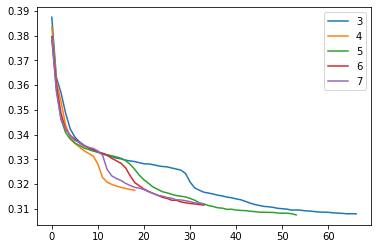

In [147]:
# evaluate model and plot learning curve of model with given number of layers

num_layers = [3,4,5,6,7]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_l2_model(n_layers, x_train_final_z.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled_z.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [ ]:
# evaluate model and plot learning curve of model with given number of layers

num_layers = [3,4,5,6,7]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_L1_model(n_layers, x_train_final,
                                     y_train_final, x_test_scaled, y_test,
                                     x_val,y_val,no_recover)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [ ]:
# evaluate model and plot learning curve of model with given number of layers

num_layers = [8,10,12,14]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, x_train_final,y_train_final, x_test_scaled, y_test,x_val,y_val)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [ ]:
history, result = evaluate_model(n_layers, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)

In [151]:
kr = regularizers.l2(0.005)
opt = Adam(learning_rate=.001)
L2_model = models.Sequential()
L2_model.add(layers.Dense(50, activation='tanh', kernel_regularizer=kr, input_shape=(53,)))
# Add another hidden layer
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
# Add an output layer
L2_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
L2_model.compile(optimizer=opt, 
                 loss='binary_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_val = L2_model.fit(x_train_final.drop(columns=sub_grade_columns,axis=1), 
                            y_train_final, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(x_val.drop(columns=sub_grade_columns,axis=1), y_val))

Epoch 1/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.5110 - acc: 0.7994 - val_loss: 0.4664 - val_acc: 0.7990
Epoch 2/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4632 - acc: 0.8010 - val_loss: 0.4709 - val_acc: 0.8012
Epoch 3/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4577 - acc: 0.8015 - val_loss: 0.4535 - val_acc: 0.8042
Epoch 4/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4542 - acc: 0.8019 - val_loss: 0.4573 - val_acc: 0.7946
Epoch 5/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4520 - acc: 0.8020 - val_loss: 0.4566 - val_acc: 0.7945
Epoch 6/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4505 - acc: 0.8022 - val_loss: 0.4523 - val_acc: 0.7977
Epoch 7/150
5358/5358 [==============================] - 10s 2ms/step - loss: 0.4481 - acc: 0.8033 - val_loss: 0.4426 - val_acc: 0.8069
Epoch 8/150
5358/5358 [==============================]

Epoch 61/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4268 - acc: 0.8117 - val_loss: 0.4218 - val_acc: 0.8152
Epoch 62/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4268 - acc: 0.8119 - val_loss: 0.4327 - val_acc: 0.8118
Epoch 63/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4266 - acc: 0.8121 - val_loss: 0.4239 - val_acc: 0.8112
Epoch 64/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4264 - acc: 0.8120 - val_loss: 0.4300 - val_acc: 0.8125
Epoch 65/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4269 - acc: 0.8116 - val_loss: 0.4221 - val_acc: 0.8150
Epoch 66/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4263 - acc: 0.8118 - val_loss: 0.4266 - val_acc: 0.8132
Epoch 67/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4268 - acc: 0.8117 - val_loss: 0.4215 - val_acc: 0.8151
Epoch 68/150
5358/5358 [========================

5358/5358 [==============================] - 8s 2ms/step - loss: 0.4251 - acc: 0.8116 - val_loss: 0.4343 - val_acc: 0.7977
Epoch 122/150
5358/5358 [==============================] - 8s 2ms/step - loss: 0.4255 - acc: 0.8113 - val_loss: 0.4212 - val_acc: 0.8152
Epoch 123/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4252 - acc: 0.8117 - val_loss: 0.4663 - val_acc: 0.7657
Epoch 124/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4252 - acc: 0.8116 - val_loss: 0.4229 - val_acc: 0.8112
Epoch 125/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4249 - acc: 0.8117 - val_loss: 0.4219 - val_acc: 0.8149
Epoch 126/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4252 - acc: 0.8115 - val_loss: 0.4326 - val_acc: 0.8116
Epoch 127/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4250 - acc: 0.8116 - val_loss: 0.4365 - val_acc: 0.8094
Epoch 128/150
5358/5358 [==============================